# **Mobile Games A/B Testing - Cookie Cats**

*[Based on Mobile Games A/B Testing with Cookie Cats Project by DataCamp](https://app.datacamp.com/learn/projects/184)*


*by Abdurrahman Shiddiq Thaha*

*November 2022*

---

## Content

1. Introduction
2. Import Libraries
3. Data Loading
4. Exploratory Data Analysis (EDA)
5. Data Preprocessing
6. Model Definition
7. Model Training
8. Model Evaluation
9. Model Saving
10. Model Inference
11. Conclusion

##  1. Introduction 

### 1.1 Background

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats. We're not kidding!

<center><iframe width="560" height="315" src="https://www.youtube.com/embed/GaP5f0jVTWE" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></iframe></center>

As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase.

### 1.2 Problem Statement

Create an analysis of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds.

## 2. Import Libraries 

These are libraries that are used in this assignment:

### Base

- numpy : Used to do mathematical calculation necessary in the data analysis

- pandas : Used to load and process data

- seaborn : Used to do an alternative data visualization

- matplotlib : Used to visualize data

### Hypothesis Testing

- scipy.stats : Used to do statistical calculation and hypothesis testing

### Configuration

- warnings : Used to ignore any warning

In [313]:
# Base
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

# Hypothesis Testing
from scipy.stats import shapiro
import scipy.stats as stats

# Configuration
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
sns.set_style(style='white')

pd.set_option('display.max_columns', None)

np.random.seed(420)

## 3. Data Loading 

We have been provided with 1 dataset . The description for what the dataset contain is given below: 


- **cookie_cats.csv** : he data is from 90,189 players that installed the game while the AB-test was running.

The details of the dataset can be seen here [Here](https://www.kaggle.com/datasets/mursideyarkin/mobile-games-ab-testing-cookie-cats)

### • Data Description

| Variable | Definition | Description |
| --- | --- | --- |
| userid | a unique number that identifies each player |  |
| version | Whether the player put in the control group | gate_30: a gate at level 30, gate_40: a gate at level 40 |
| sum_gamerounds | the number of game round played by the player during the first week after installation |  |
| retention_1 | did the player come back and play 1 day after installing? |  |
| retention_7 | did the player come back and play 1 day after installing? |  |

When a plater install the game, they will randomly assigned to either gate_30 or gate_40

In [314]:
# Loading data
df = pd.read_csv('data/cookie_cats.csv')

In [315]:
# Duplicate Dataset
df_ab = df.copy()

In [316]:
# Checking the shape of the dataset
df.shape

(90189, 5)

This dataset has 90189 rows and 5 columns

In [317]:
# Look at the first 3 rows
df_ab.head(3)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False


In [318]:
# Look at the last 3 rows
df_ab.tail(3)

,userid,version,sum_gamerounds,retention_1,retention_7
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False
90188,9999861,gate_40,16,False,False


In [319]:
# Show concise summary of the data
df_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


- there is no column that have null values
- there are 1 columns with object datatype, 2 columns with boolean datatype and 2 columns with int64 datatype

### • Checking for duplicate

In [320]:
# Checking if the dataset have duplicate
df_ab.shape[0] - df_ab.drop_duplicates().shape[0]

0

There is not duplicate data

In [321]:
# Generate some descriptive statistics of numerical data
df_ab.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


We can see above, it seems there is an anomaly in `sum_gamerounds` where the maximum value is way beyond the 75th quartile.

In [322]:
df_ab['sum_gamerounds'].sort_values(ascending=False)

57702    49854
7912      2961
29417     2640
43671     2438
48188     2294
         ...  
59687        0
23707        0
59670        0
59645        0
45094        0
Name: sum_gamerounds, Length: 90189, dtype: int64

since it seems that only one instance is the anomaly, we will do outliers handling on that one particular entry only 

### • Outliers handling

In [323]:
# Defining a function to analyze outlier in the data

def outlier_analysis(df, col, d):
    skewness = df[col].skew()
    if skewness >= 0.5 and skewness<=0.5:
        upper = df[col].mean() + d*df[col].std()
        lower = df[col].mean() - d*df[col].std()
        method = 'Z-Score'
    else:
        q3 = df[col].quantile(0.75)
        q1 = df[col].quantile(0.25)
        iqr = q3 - q1
        upper_bound = q3 + (iqr * d)
        lower_bound = q1 - (iqr * d)
        method = 'IQR'

    outlier = df.loc[(df[col] > upper_bound) | (df[col] < lower_bound)]
    
    return outlier, method, upper_bound, lower_bound

In [324]:
# Defining a function to go through every numerical column and handle their outliers
def outlier_handling(df, column, d=3):
    for col in column:
        out, method, up, low = outlier_analysis(df, col, d)
        pct_out = (len(out)/len(df))*100
        # if outliers percentage is under 10%, we will drop the data
        if pct_out <= 10:
            df = df[(df[col]>=low) & (df[col]<=up)]
        # if outliers percentage is over 10%, we will cap the outliers 
        else:
            df[col] = df[col].apply(lambda x: up if x>=up else low if x<=low else x)
            
    return df

In [325]:
df_ab = outlier_handling(df_ab, ['sum_gamerounds'])

In [326]:
# df_ab = df_ab[df_ab['sum_gamerounds'] < df_ab['sum_gamerounds'].max()]

## 4. Exploratory Data Analysis (EDA)

There are 3 datatypes in the dataset:

1. Numerical: `sum_gamerounds`

2. Categorical/boolean: `version`, `retention_1`, `retention_7`



For each datatype, we will do different data exploration

### • Univariate

#### Numerical

For numerical data type, we will see the distribution of each column


In [327]:
num_col = ['sum_gamerounds']

In [328]:
# defining a function to plot the distribution of data
def plot_numerical(df, feature, length=16, width=14):
    if len(feature) == 1:
        fig, axes = plt.subplots(2, 1, figsize=(10,6))
        skew = df[feature[0]].skew()
            
        _ = sns.histplot(x=df[feature[0]], ax=axes[0], bins='auto', kde=True)
        axes[0].set_title(f'Distribution of {feature[0]} (skewness = {skew:.3f})')
            
            
        _ = sns.boxplot(x=df[feature[0]], ax=axes[1])
        axes[1].set_title(f'''Boxplot of {feature[0]}''')
        sns.despine()
            
        plt.tight_layout()
        
    else:
        fig, axes = plt.subplots(len(feature), 2, figsize=(length, width))
        for c, ax in zip(feature, axes):
            skew = df[c].skew()
            
            _ = sns.histplot(x=df[c], ax=ax[0], bins='auto')
            ax[0].set_title(f'Distribution of {c} (skewness = {skew:.3f})')
            
            
            _ = sns.boxplot(x=df[c], ax=ax[1])
            ax[1].set_title(f'''Boxplot of {c}''')
            sns.despine()
            
        plt.tight_layout()

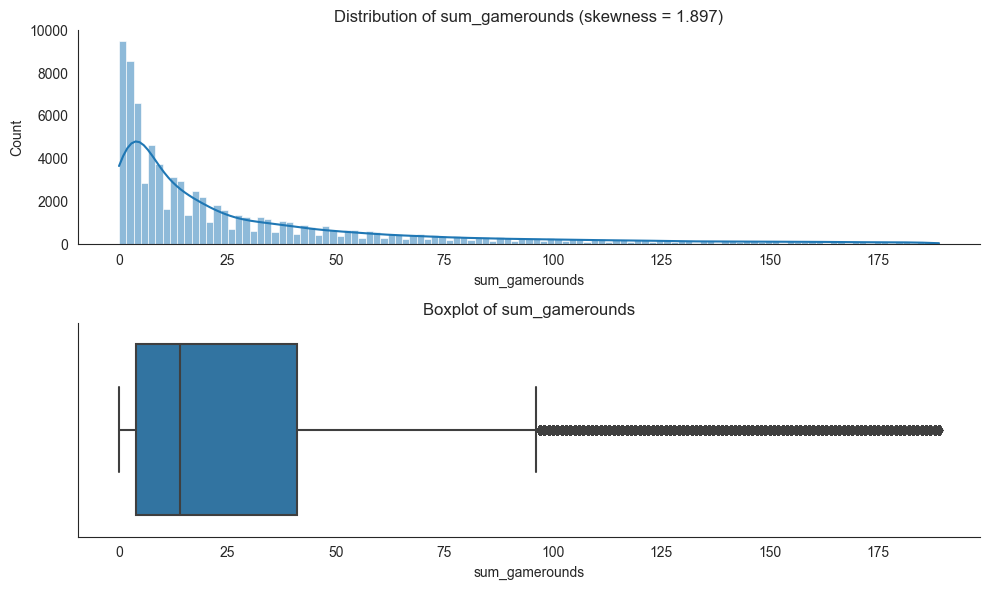

In [329]:
plot_numerical(df_ab, num_col)

Most of the players play the game at early stage and they don't continue playing and on top of that there are people who install the game then not playing the game at all.

In [330]:
df_ab['sum_gamerounds'].value_counts()[0]

3994

there are 3994 who install the game then not playing the game at all.

#### Categorical

Categorical Columns: `Marathon`, `Name`, `Category`, `CrossTraining`, `CATEGORY`

For categorical data type, we will see the distribution of category in each column

In [331]:
cat_cols = ['version', 'retention_1', 'retention_7']

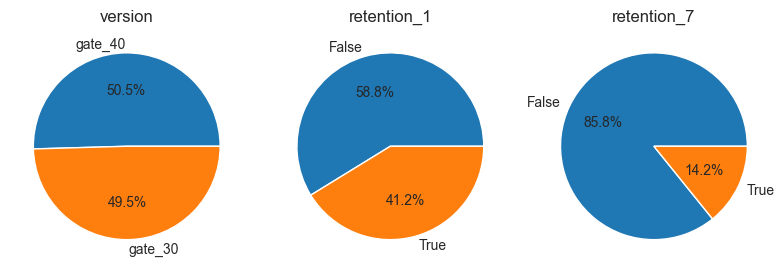

In [332]:
# create a function to only show the label when it's > 5%
def autopct(pct): 
    return ('%1.1f%%' % pct) if pct > 5 else ''

fig, axes = plt.subplots(1, 3, figsize=(8,15))

# flat the axes to be in one line of list
axes = axes.flatten()

# Use for loop to plot all of the categorical data into pie chart
for c, ax in zip(cat_cols, axes):
    _ = df_ab[c].value_counts().sort_values(ascending=False).plot(kind='pie', fontsize=10, autopct=autopct, ax=ax, title=c);
    _ = ax.set_ylabel('')
_ = plt.tight_layout()

We can see above that the proportion of version gate_40 and gate_30 is arguably the same. However, from the retention_1 and retention_7 chart, we can see that only 58.8% of players didn't play the game 1 day after installing, and to make matter worse, 85.8% of players didn't play the game 7 day after installing.

### • Bivariate

#### What is the distribution of sum_gamerounds based on the version?

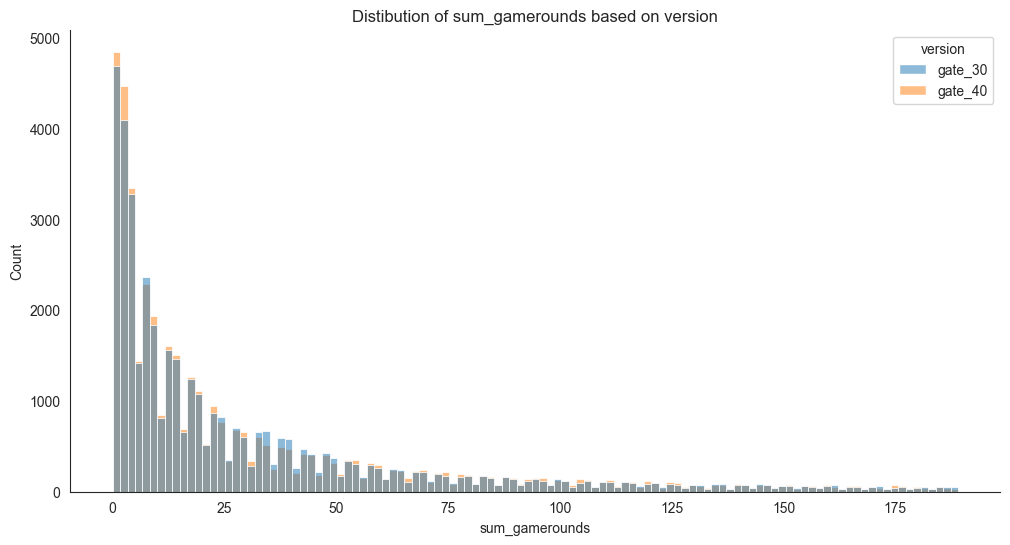

In [333]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))


_ = sns.histplot(x=df_ab['sum_gamerounds'], ax=ax, bins='auto', hue=df_ab['version'])
_.set_title(f'Distibution of sum_gamerounds based on version');
sns.despine()
    

As can be seen above, it appears that there is no significance different on sum_gamerounds for gate_30 and gate_40

#### What is the distribution of Retention_1 based on the version?

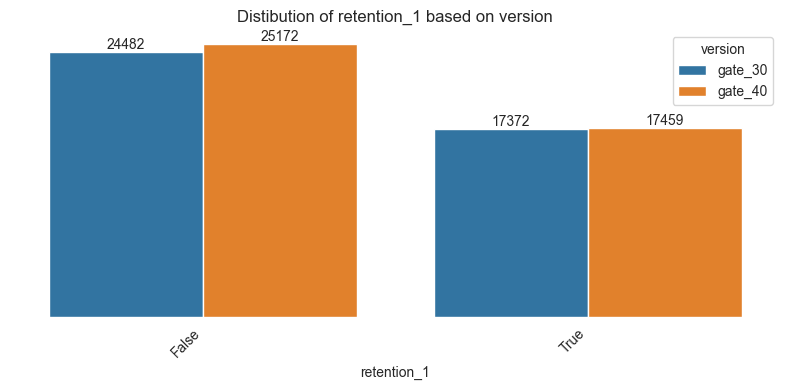

In [334]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
_ = sns.countplot(df_ab, x='retention_1', hue='version', ax=ax)
_.bar_label(_.containers[0]);
_.bar_label(_.containers[1]);

_.set_yticks([])
_.set_ylabel('')

_.set_title(f'Distibution of retention_1 based on version')
plt.xticks(rotation=45, ha='right');
sns.despine(bottom = True, left = True)
plt.tight_layout()

As the figure showed, the proportion of retention_1 for both True and False based on the version is pretty similar.

#### What is the distribution of Retention_7 based on the version?

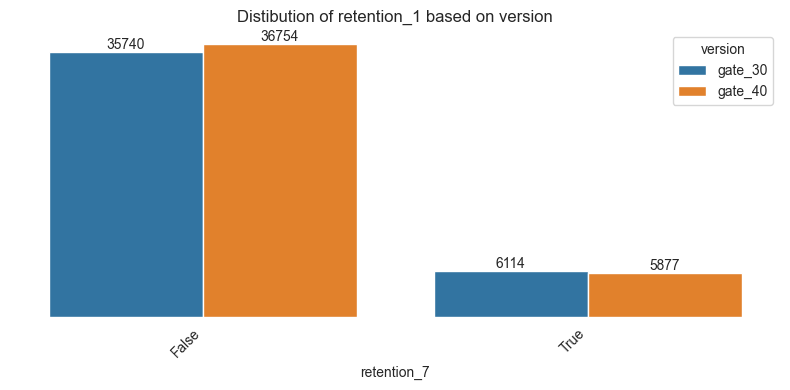

In [335]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
_ = sns.countplot(df_ab, x='retention_7', hue='version', ax=ax)
_.bar_label(_.containers[0]);
_.bar_label(_.containers[1]);

_.set_yticks([])
_.set_ylabel('')

_.set_title(f'Distibution of retention_1 based on version')
plt.xticks(rotation=45, ha='right');
sns.despine(bottom = True, left = True)
plt.tight_layout()

similar to the previous one, the proportion of retention_7 for both True and False based on the version is alike.

In [336]:
df_ab.groupby(['version', 'retention_1', 'retention_7'])['sum_gamerounds'].agg(["count", "median", "mean", "std", "max"]).reset_index()

,version,retention_1,retention_7,count,median,mean,std,max
0,gate_30,False,False,22804,6.0,11.347746,16.912217,188
1,gate_30,False,True,1678,39.0,52.019070,44.704859,189
2,gate_30,True,False,12936,31.0,42.209184,37.009030,189
3,gate_30,True,True,4436,82.0,88.310866,48.999782,189
4,gate_40,False,False,23552,6.0,11.420007,17.282023,189
5,gate_40,False,True,1620,40.0,53.440741,45.363669,189
6,gate_40,True,False,13202,31.0,42.889259,37.505397,189
7,gate_40,True,True,4257,87.0,91.032417,49.197721,189


## 5. A/B Testing

### Assumptions:

- Check Normality
- If Normal Distribution, Check Homogenity

### Steps:
- Split & Define Control Group & Test Group
- Apply Shapiro Test for normality
- If parametric apply Levene Test for homogeneity of variances
- If Parametric + homogeneity of variances apply T-Test
- If Parametric - homogeneity of variances apply Welch Test
- If Non-parametric apply Mann Whitney U Test directly

In [337]:
# Define A/B groups
df_ab["version"] = np.where(df_ab['version'] == "gate_30", "A", "B")
df_ab.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,A,3,False,False
1,337,A,38,True,False
2,377,B,165,True,False
3,483,B,1,False,False
4,488,B,179,True,True


In [338]:
# defining an A/B Testing test function
def AB_test(df, group, target):
    
    # split A/B
    groupA = df[df[group] == 'A'][target]
    groupB = df[df[group] == 'B'][target]
    
    # assumption: normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupA)[1] < 0.05
    # H0: distribution is normal/P-value >= 0.05 - False
    # H1: Distribution is not normal/P-value < 0.05 - True    
    
    if (ntA == False) & (ntB == False): # H0: distribution is normal
        # parametric test
        test_type = 'Parametric'
        
        # Assumption: Homogeneity if variances
        levenetest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity/P-value >= 0.05 - False
        # H1: Heterogeneous/P-value < 0.05 - True
        
        if levenetest == False: # homogeneity
            homogeneity = 'Yes'
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: A == B/P-value >= 0.05 - True
            # H1: A != B/P-value < 0.05 - False
            
        else: # heterogeneous
            homogeneity = 'Yes'
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: A == B/P-value >= 0.05 - True
            # H1: A != B/P-value < 0.05 - False
            
    else: # Non parametric test
        test_type = 'Non-Parametric'
        ttest = stats.mannwhitneyu(groupA, groupB)[1]
        # H0: A == B/P-value >= 0.05 - True
        # H1: A != B/P-value < 0.05 - False
        
    if ttest < 0.05:
        ab_test_result = 'Reject H0' 
    else:
        ab_test_result = 'Fail to Reject H0' 
        
    if ab_test_result == 'Fail to Reject H0':
        comment = 'A/B groups are similar!'
    else:
        comment = 'A/B groups are not similar!'
    
    
    # Print Hypothesis
    print('========='*10, '\n')
    print('A/B Testing Hypothesis')
    print('H0: A == B')
    print('H1: A != B', '\n')
    print('---------'*10, '\n')
    # Print result
    if test_type == 'Parametric':
        print(f'Test_type: {test_type}')
        print(f'Homogeneity: {Homogeneity}')
        print(f'A/B Hypothesis: {ab_test_result}')
        print(f'p-value: {ttest}')
        print(f'Comment: {comment}', '\n')
    
    else:
        print(f'Test_type: {test_type}')
        print(f'A/B Hypothesis: {ab_test_result}')
        print(f'p-value: {ttest:0.4f}')
        print(f'Comment: {comment}', '\n')      
        
            
    print('========='*10)

In [341]:
'0OKFQCKNS' == '0OKFQCKNS'

True

In [339]:
# Apply A/B Testing
AB_test(df_ab, "version", "sum_gamerounds")


A/B Testing Hypothesis
H0: A == B
H1: A != B 

------------------------------------------------------------------------------------------ 

Test_type: Non-Parametric
A/B Hypothesis: Fail to Reject H0
p-value: 0.0557
Comment: A/B groups are similar! 



## 6. Conclusion 

Let's remind the goal of this project. Our goal in this project is to reate an analysis of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds.

First thing first, we investigated relationships and structures in the data. There was no duplicate and missing value problem but there was outlier problem that we handled. We also explored the data further in order to help us to understand the data and problem

After conducting A/B testing, the analysis result gives us some important information. Shapir testing rejected H0 for normality assumption, which means that our data is not normally distributed therefore we needed to apply a Non-parametric test as called Mann Whitney U to compare the two groups. As a result, Mann Whitney U testing failed to reject H0 hypothesis and we learned that A/B groups are similar.

Ultimately, There is no statistically significant difference between two groups about moving first gate from level 30 to level 40 for game rounds.